(coupled:solution)=
### Boundary layer model with coupled surface energy balance and soil module

The aim of this exercise is to include the SEB and soil module in the boundary layer model. 

**Step 1**: Load the SEB model. 

In [1]:
import math
import numpy as np
from scipy.optimize import minimize, minimize_scalar
import matplotlib.pyplot as plt

%matplotlib inline


def EB_fluxes(T_0,T_a,f,albedo,G,p,rho,U_L,z,z_0):
    """ This function calculates the energy fluxes from the following quantities:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    # Some constants
    c_p = 1004.0      # specific heat [J kg^-1 K^-1]
    kappa = 0.40      # Von Karman constant [-]
    sigma = 5.67e-8   # Stefan-Bolzmann constant
    
    # Bulk coefficients 
    Cs_t = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )
    Cs_q = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )  
    
    # Correction factor for incoming longwave radiation
    eps_cs = 0.23 + 0.433 * np.power(100*(f*E_sat(T_a))/T_a,1.0/8.0)
    
    # Select the appropriate latent heat constant
    L = 2.83e6 # latent heat for sublimation

    # Calculate turbulent fluxes
    H_0 = rho * c_p  * Cs_t * U_L * (T_0-T_a)
    E_0 = rho * ((L*0.622)/p) * Cs_q * U_L * (E_sat(T_0)-f*E_sat(T_a))
    
    # Calculate radiation budget
    L_d = eps_cs * sigma * (T_a)**4
    L_u = sigma * (T_0)**4 
    Q_0 = (1-albedo)*G #+ L_d - L_u

    return (Q_0, L_d, L_u, H_0, E_0)

def E_sat(T):
    """ Saturation water vapor equation """
    Ew = 6.112 * np.exp((17.67*(T-273.16)) / ((T-29.66)))
    return Ew


def optim_T0(x,T_a,f,albedo,G,p,rho,U_L,z,z0):
    """ Optimization function for surface temperature:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    Q_0, L_d, L_u, H_0, E_0 = EB_fluxes(x,T_a,f,albedo,G,p,rho,U_L,z,z0)
    
    # Get residual for optimization
    res = np.abs(Q_0+L_d-L_u-H_0-E_0)

    # return the residuals
    return res

**Step 2**: Extend the heat equation to 2D.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math


def heat_equation_time_2D(T, dz, dt):
    """ This is a 2D version of the heat equation. It takes only the 2D-temperature
    field, dz the spacing in the vertical and the timestep dt. The function returns the
    updated temperature field."""

    # Definitions and assignments
    K   = 1.2e-6               # Conductivity
 
    # Define index arrays 
    Nz = T.shape[0]
    k  = np.arange(1,Nz-1)  # all indices at location i
    kr  = np.arange(2,Nz)   # all indices at location i+1
    kl  = np.arange(0,Nz-2) # all indices at location i-1

    # Create array for new temperature values
    Tnew = T

    # Loop over x-direction
    for x in range(T.shape[1]):

        # Set lower BC - Neumann condition
        T[Nz-1,:] = T[Nz-2,:]
        
        # Update temperature using indices arrays
        Tnew[k,x] = T[k,x] + ((T[kr,x] + T[kl,x] - 2*T[k,x])/dz**2) * dt * K
        
        # Copy the new temperature als old timestep values (used for the 
        # next time loop step)
        T = Tnew


    # return temperature array, grid spacing, and number of integration steps
    return T

**Step 3**: Test the soil module

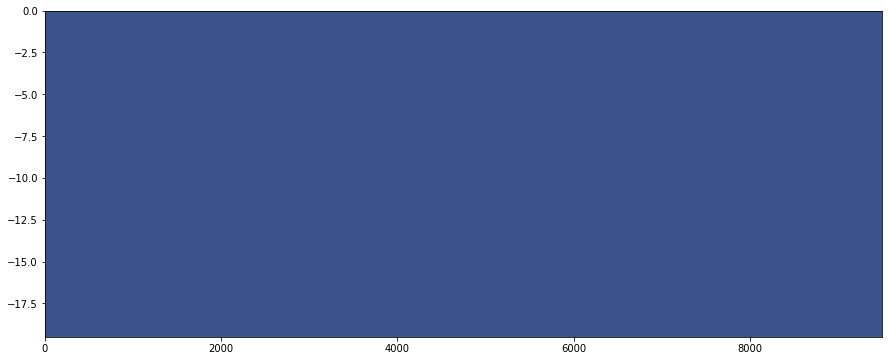

In [3]:
# Define necessary variables and parameters
# for the soil module
Nx = 20
Nz = 40
dx = 500
dz = 0.5
x = np.arange(0, Nx*dx, dx)
z = np.arange(0, -Nz*dz, -dz)

# Initial temperature field
T = np.zeros((Nz, Nx))

# Do some test runs
for t in range(4):
    T = heat_equation_time_2D(T, 1, 86400)

plt.figure(figsize=(15,6))
plt.contourf(x, z, T);

**Step 4**: Now, combine the SEB module with the soil module

In [4]:
# Define necessary variables and parameters
# for the SEB
T_0    = 283.0   # Surface temperature
T_a    = 280.0   # Air temperature 
f      = 0.7     # Relative humidity
albedo = 0.3     # albedo
G      = 700.0   # Incoming shortwave radiation
rho    = 1.1     # Air density
U      = 2.0     # Wind velocity
z      =  2.0    # Measurement height
z0     = 1e-3    # Roughness length
p      = 1013    # Pressure

# Define necessary variables and parameters
# for the soil module
Nx = 20
Nz = 40
dx = 500
dz = 0.5

# Initial temperature field
T = np.zeros((Nz, Nx))

# Integration parameters
dt = 3600
integration = 12


# Iterate over time
for t in range(integration):
    
    # Do some artificial global radiation
    G = np.maximum(700 * np.sin((2*math.pi*t)/24), 0)
    
    # Loop over all x-cells and calculate the surface temperature
    for x in range(T.shape[1]):
        
        # Set the initial guess for the temperature optimization
        T_0 = T[0,x]
        
        #-----------------------------------
        # Solve for the surface temperature
        #-----------------------------------
        res = minimize(optim_T0,x0=T_0,args=(T_a,f,albedo,G,p,rho,U,z,z0),bounds=((None,400),), \
                method='L-BFGS-B',options={'eps':1e-8})
        
        # Assign optimized surface temperature to the temperature array
        T[0,x] = res.x
      
    #-------------------------
    # Solve the heat equation
    #-------------------------
    T = heat_equation_time_2D(T, dz, dt)
    


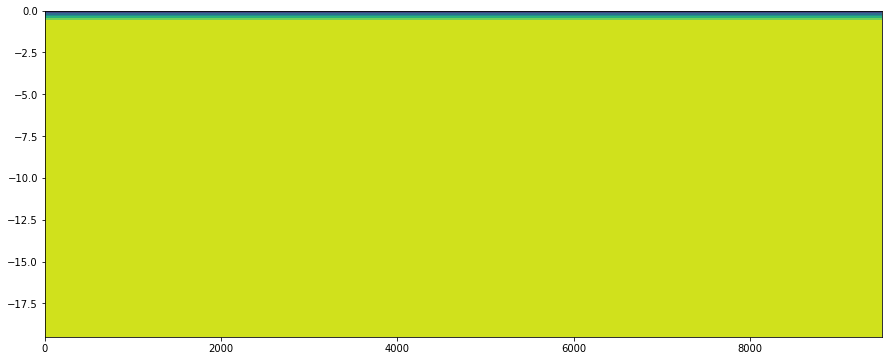

In [5]:
# Do some plots
x = np.arange(0, Nx*dx, dx)
z = np.arange(0, -Nz*dz, -dz)

plt.figure(figsize=(15,6))
plt.contourf(x,z,T)

**Step 5**: Add the boundary layer model.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
    
# --------------------------
# Auxiliary functions
# --------------------------
def saturation_water_vapor(T):
    """ Calculates the saturation water vapor pressure [Pa]"""
    return ( 6.122*np.exp( (17.67*(T-273.16))/(T-29.66) ) )

def hypsometric_eqn(p0, Tv, z):
    """Hypsometric equation to calculate the pressure [hPa] at a certain height[m]
       when the surface pressure is given
       p0 :: surface pressure [hPa]
       Tv :: mean virtual temperature of atmosphere [K]
       z  :: height above ground [m]
    """
    return(p0/(np.exp((9.81*z)/(287.4*Tv) )))

def mixing_ratio(theta, p0, Tv, z):
    """ Calculates the mixing ratio from
        theta :: temperature [K]
        p0    :: surface pressure [hPa]
        Tv    :: mean virtual temperature of atmosphere [K]
        z     :: height [m]
    """
    return(622.97 * (saturation_water_vapor(theta)/(hypsometric_eqn(p0,Tv,z)-saturation_water_vapor(theta))))

def make_plot(data, x, z, levels, title, unit, xlab, zlab, cmap='RdBu_r', size=(18,5)):
    """ Useful function for plotting 2D-fields as contour plot"""
    
    # Create figure
    fig, ax = plt.subplots(1,1,figsize=size);
    cn0 = ax.contourf(x,z,data,10,origin='lower',levels=levels,cmap=cmap);
    
    # Add the colorbar and set ticks and labels
    cbar= fig.colorbar(cn0, ax=ax, orientation='vertical')
    cbar.set_label(label=unit, size=16)
    cbar.ax.tick_params(labelsize=14)
    
    # Add labels and modify ticks
    ax.set_xlabel(xlab, fontsize=14)
    ax.set_ylabel(zlab, fontsize=14)
    ax.set_title(title)
    
    # return the handler to the figure axes
    return ax
    
    
    
def boundary_layer_evolution_moisture(theta, q, u, K, dx, dz, Nx, Nz, dt):
    """ Simple advection-diffusion equation.
    
    integration :: Integration time in seconds
    Nz          :: Number of grid points
    dt          :: time step in seconds
    K           :: turbulent diffusivity
    u           :: Speed of fluid
    """
    
    # Define index arrays 
    # Since this a 2D problem we need to define two index arrays.
    # The first set of index arrays is used for indexing in x-direction. This
    # is needed to calculate the derivatives in x-direction (advection)
    k   = np.arange(1,Nx-1) # center cell
    kr  = np.arange(2,Nx)   # cells to the right
    kl  = np.arange(0,Nx-2) # cells to the left
    
    # The second set of index arrays is used for indexing in z-direction. This
    # is needed to calculate the derivates in z-direction (turbulent diffusion)
    m   = np.arange(1,Nz-1) # center cell
    mu  = np.arange(2,Nz)   # cells above 
    md  = np.arange(0,Nz-2) # cells below

    # --------------------------
    # Init other arrays
    # --------------------------
    cov = np.zeros((Nz, Nx))        # Empty array for the covariances
    adv = np.zeros((Nz, Nx))        # Empty array for the advection term 
    
    # --------------------------
    # Dimensionless parameters
    # --------------------------
    c = (u*dt)/dx
    d = (K*dt)/(dz**2)

    # --------------------------
    # Integrate the model
    # --------------------------

    # Set BC top (Neumann condition)
    # The last term accounts for the fixed gradient of 0.01
    theta[Nz-1, :] = theta[Nz-2, :]
    
    # Set top BC for moisture
    q[Nz-1, :] = q[Nz-2, :] 

    # Set BC right (Dirichlet condition)
    theta[:, Nx-1] = theta[:, Nx-2]

    # Set right BC for moisture
    q[:, Nx-1] = q[:, Nx-2]

    # We need to keep track of the old values for calculating the new derivatives.
    # That means, the temperature value a grid cell is calculated from its values 
    # plus the correction term calculated from the old values. This guarantees that
    # the gradients for the x an z direction are based on the same old values.
    old = theta
    old_q = q

    # First update grid cells in z-direction. Here, we loop over all x grid cells and
    # use the index arrays m, mu, md to calculate the gradients for the
    # turbulent diffusion (which only depends on z)
    for x in range(1,Nx-1):
        # Update temperature including lapse rate 
        theta[m,x] = theta[m,x] + ((K*dt)/(dz**2))*(old[mu,x]+old[md,x]-2*old[m,x]) + lapse_rate
        # Moisture transport (turbulent diffusion)
        q[m,x] = q[m,x] + ((K*dt)/(dz**2))*(old_q[mu,x]+old_q[md,x]-2*old_q[m,x])
        # Calculate the warming rate [K/s] by covariance
        cov[m,x] = ((K)/(dz**2))*(old[mu,x]+old[md,x]-2*old[m,x])

    # Then update grid cells in x-direction. Here, we loop over all z grid cells and
    # use the index arrays k, kl, kr to calculate the gradients for the
    # advection (which only depends on x)
    for z in range(1,Nz-1):
        # temperature advection
        theta[z,k] = theta[z,k] - ((u*dt)/(dx))*(old[z,k]-old[z,kl])
        # moisture advection
        q[z,k] = q[z,k] - ((u*dt)/(dx))*(old_q[z,k]-old_q[z,kl])
        # Calculate the warming rate [K/s] by the horizontal advection 
        # Note: Here, we use a so-called upwind-scheme (backward discretization)
        adv[z,k] = - (u/dx)*(old[z,k]-old[z,kl])

    # Calculate new saturation mixing ratio
    qsat = mixing_ratio(theta, 1013, 270, height)

    # Then the relative humidity using qsat
    # Limit the relative humidity to 100 %
    rH = np.minimum(q/qsat, 1)

    # Return results    
    return theta, q, qsat, rH, cov, adv, c, d, np.arange(0, Nx*dx, dx), np.arange(0, Nz*dz, dz)


**Step 6**: Combine the boundary layer model with the SEB and soil modules.

In [7]:
#--------------------------------------------
# General parameters
#--------------------------------------------
lake_from = 10 # Where does the lake start (grid cell)
lake_to = 20   # where does the lake end (grid cell)
Nx = 50        # how many grid cells in x-direction
dx = 500       # grid spacing in x

# Integration parameters
dt = 60             # timestep in seconds
integration = 4*60 # number of integration steps

#--------------------------------------------
# Define necessary variables and parameters
# for the SEB
#--------------------------------------------
albedo = 0.3     # albedo [-]
G      = 200.0   # Incoming shortwave radiation
rho    = 1.1     # Air density [kg m^-3]
U      = 5.0     # Wind velocity [m/s]
z      = 2.0     # Measurement height [m]
z0     = 1e-3    # Roughness length [m]
p      = 1013    # Pressure [hPa]

# Just for fun!!!
albedo = 0.3 * np.ones(Nx)
albedo[lake_to:-1] = 0.5

#--------------------------------------------
# Define necessary variables and parameters
# for the soil module
#--------------------------------------------
Nz = 10      # Number of grid cells in the soil
dz = 0.1    # grid spacing [m]
Tsoil = 268  # Initial soil temperatures
Tlake = 278  # Lake temperatures

# Initial soil temperature field
T = Tsoil * np.ones((Nz, Nx))
T[:, lake_from:lake_to] = Tlake


# --------------------------------------
# Initial atmospheric temperature field
# --------------------------------------
Nza = 20 # Number of vertical grid cells in the atmosphere
dza = 10  # Grid spacing [m]

# Neutral stratification with lapse rate of 0.01 K/m
# Create a 1D-array with the vertical temperature distribution
# Surface = 268 K, decreasing according to the dry-adiabative lapse rate 0.01 K/m
Tatm = 268           # initial temperature of the atmosphere [K]
lapse_rate = -0.01   # lapse rate [K/m]
theta_vec = np.array([Tatm + lapse_rate * (dza * z) for z in range(Nza)])
theta = np.array([theta_vec,] * Nx).transpose() 

# The lower temperature boundary needs to be updated where there is the lake
theta[0, lake_from:lake_to] = Tlake

# Make height grid
height = np.array([np.arange(0,Nza*dza,dza),] * Nx).transpose()

# --------------------------
# Initialize moisture fields 
# --------------------------
# Init saturation mixing ratio array
qsat = mixing_ratio(theta, 1013, Tatm, height)

# Use qsat to derive mixing ratio at each grid cell assuming a 
# decreasing relative humidity from 70 % at the surfacee to 20 % at the top
q = (qsat.T * np.linspace(0.8, 0.2, Nza)).T

# The lower moisture boundary needs to be updated where there is the lake
# Here, were set the moisture at the lower boundary from the grid cell 50
# to 150 to a mixing ratio of 0.9 times the saturation mixing ratio
q[0, lake_from:lake_to] = 0.95 * qsat[0, lake_from:lake_to] 


# Iterate over time
for t in range(integration):
    
    # Also for fun!!! Variation in the global radiation
    #if t==0:
    #    G = 0
    #else:
    #    G = 700 * np.sin( (2*np.pi*t*dt)/84600 )
        
    # Loop over all x-cells and calculate the surface temperature
    for x in range(T.shape[1]):
        
        # Keep the same temperature for the lake (no heating)
        if (x>=lake_from) & (x<=lake_to):
            T[0,x] = Tlake
        else:
            # Set the initial guess for the temperature optimization
            T_0 = T[0,x]

            #-----------------------------------
            # Solve for the surface temperature
            #-----------------------------------
            # The 2m temperature and mixing ratio is taken from the 
            # boundary layer model (theta)
            res = minimize(optim_T0,x0=T_0,args=(theta[1,x],q[1,x]/qsat[1,x],
                    albedo[x],G,p,rho,U,z,z0),bounds=((None,400),), \
                    method='L-BFGS-B',options={'eps':1e-8})

            # Assign optimized surface temperature to the temperature array
            T[0,x] = res.x

    #-------------------------
    # Solve the heat equation
    #-------------------------
    T = heat_equation_time_2D(T, dz, dt)

    #-------------------------
    # Solve the BL model
    #-------------------------
    # First, set the surface temperature from the soil module
    theta[0,:] = T[0,:]
    theta, q, qsat, rH, cov, adv, c, d, xa, za = boundary_layer_evolution_moisture(theta=theta, 
        q=q, u=U, K=0.5, dx=dx, dz=dza, Nx=Nx, Nz=Nza, dt=dt)

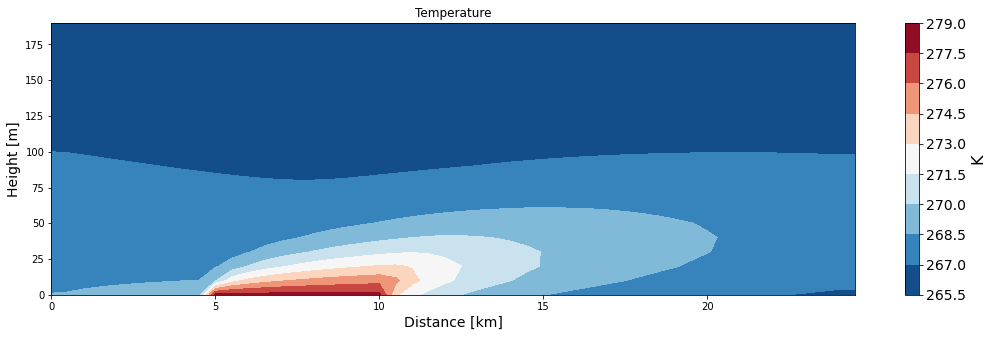

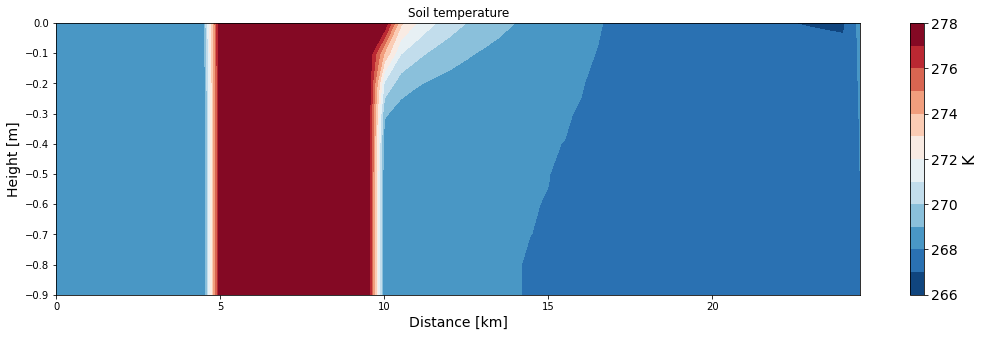

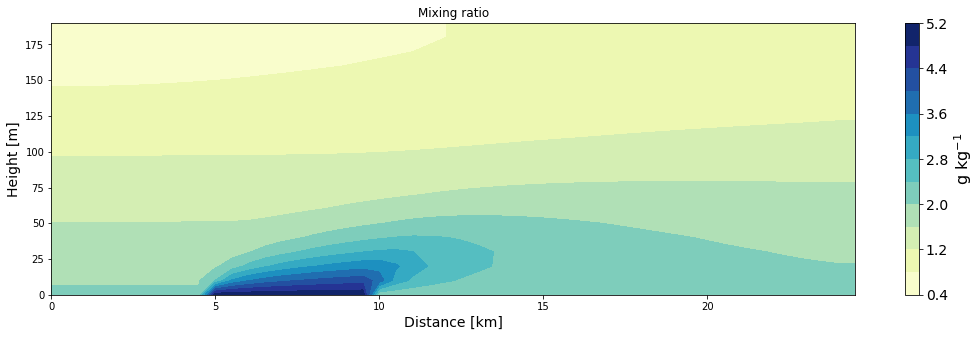

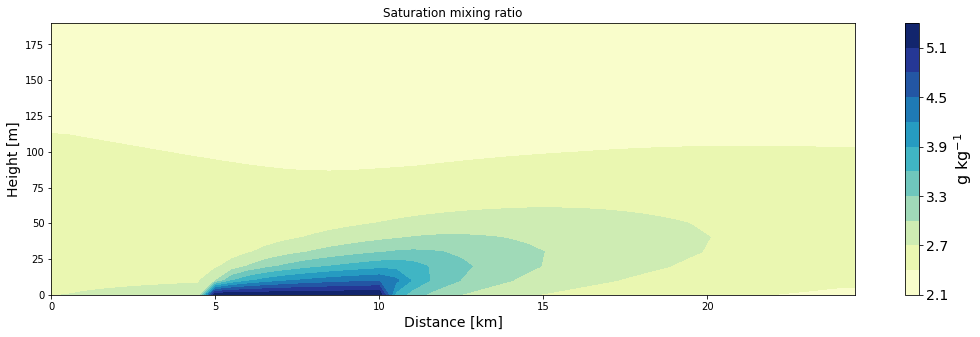

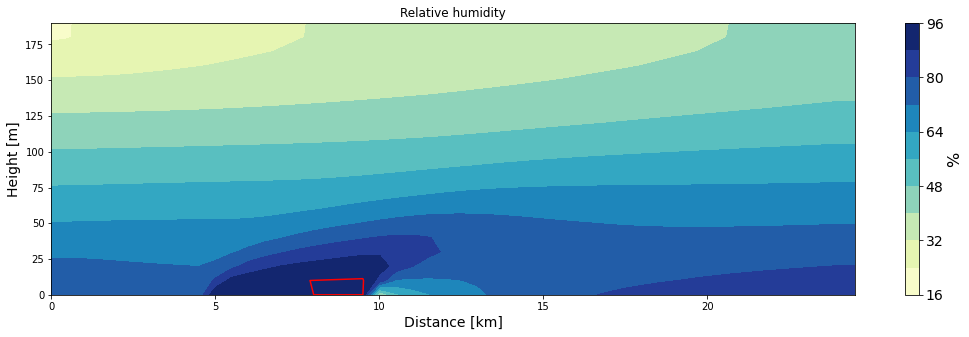

In [8]:
# Create 2D plot for the covariance
ax = make_plot(theta, x=xa/1000, z=za, levels=11, title='Temperature', unit='K', 
               xlab='Distance [km]', zlab='Height [m]', cmap='RdBu_r')

ax = make_plot(T, x=xa/1000, z=np.arange(0, -Nz*dz, -dz), levels=11, title='Soil temperature', unit='K', 
               xlab='Distance [km]', zlab='Height [m]', cmap='RdBu_r')

# Create 2D plot for the covariance
ax = make_plot(q, x=xa/1000, z=za, levels=11, title='Mixing ratio', unit='g kg$^{-1}$', 
               xlab='Distance [km]', zlab='Height [m]', cmap='YlGnBu')

# Create 2D plot for the covariance
ax = make_plot(qsat, x=xa/1000, z=za, levels=11, title='Saturation mixing ratio', unit='g kg$^{-1}$', 
               xlab='Distance [km]', zlab='Height [m]', cmap='YlGnBu')

# Create 2D plot for the covariance
ax = make_plot(rH*100, x=xa/1000, z=za, levels=11, title='Relative humidity', unit='%', 
               xlab='Distance [km]', zlab='Height [m]', cmap='YlGnBu')

ax.contour(xa/1000, za, rH, levels=[0.95,1.0],colors='red');